In [57]:
# instalando a biblioteca bs4 para web scraping
# !pip install bs4

In [58]:
from urllib.request import urlopen, urlretrieve, Request
from urllib.error import URLError, HTTPError
from bs4 import BeautifulSoup
import pandas as pd

import warnings
warnings.filterwarnings('ignore')


# obtendo o html
url = 'http://www.ipeadata.gov.br/ExibeSerie.aspx?module=m&serid=1650971490&oper=view'
headers = {"User-Agent": "Mozilla/5.0 (Windows NT 10.0; Win64, x64)"}

req = Request(url, headers=headers)
response = urlopen(req)
html = response.read()
soup = BeautifulSoup(html, 'html.parser')



In [59]:
# extraindo os dados da tabela
tabela = soup.find('table', id='grd_DXMainTable')


In [60]:
# extraindo os dados das linhas da tabela
colunas = tabela.find_all('td', class_='dxgv')



In [61]:
# criando listas para armazenar data e valor
lista_data = []
lista_valor = []

for coluna in colunas:
    texto = str(coluna.getText())
    if (',' not in texto):
      lista_data.append(texto)
    else:
      lista_valor.append(texto)

In [62]:
# criando um dicionario de dados para armazenar os dados extraídos nas listas criadas
dic_valores = {'Data': lista_data, 'Valor': lista_valor}

In [63]:
# criando um dataframe passando o dicionario como argumento
df_petroleo = pd.DataFrame(dic_valores)

In [64]:
# criando um arquivo csv com os dados obtidos
df_petroleo.to_csv('petroleo.csv', index=False)


In [65]:
# visualizando os dados
df_petroleo.head()

,Data,Valor
0,22/04/2024,"87,30"
1,19/04/2024,"87,96"
2,18/04/2024,"88,34"
3,17/04/2024,"89,54"
4,16/04/2024,"91,29"


In [66]:
# visalizando as informacoes sobre os dados
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11155 entries, 0 to 11154
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   Data    11155 non-null  object
 1   Valor   11155 non-null  object
dtypes: object(2)
memory usage: 174.4+ KB


In [67]:
# precisamos converter a coluna Valor para numeric e a coluna Data para date
# substituir virgula por ponto para poder converter o valor em decimal
df_petroleo.Valor = df_petroleo.Valor.str.replace(',', '.')

In [68]:
# converter a coluna Valor para Numeric
df_petroleo.Valor = pd.to_numeric(df_petroleo.Valor)

In [69]:
# converter a coluna Data para o tipo Data
df_petroleo.Data = pd.to_datetime(df_petroleo.Data)

In [70]:
# ordenando o dataframe em ordem crescente de data
df_petroleo = df_petroleo.sort_values(by=['Data'])

In [71]:
# conferindo os valores convertidos
df_petroleo.info()

<class 'pandas.core.frame.DataFrame'>
Index: 11155 entries, 11154 to 0
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Data    11155 non-null  datetime64[ns]
 1   Valor   11155 non-null  float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 261.4 KB


In [72]:
# visualizando conjunto de estatísticas descritivas dos valores do barril
df_petroleo.Valor.describe()

count    11155.000000
mean        52.982205
std         33.228616
min          9.100000
25%         20.480000
50%         48.160000
75%         76.235000
max        143.950000
Name: Valor, dtype: float64

In [73]:
# apresentando os valores para o dataframe criado
df_petroleo.head()

,Data,Valor
11154,1987-05-20,18.63
11153,1987-05-21,18.45
11152,1987-05-22,18.55
11151,1987-05-25,18.60
11150,1987-05-26,18.63


In [74]:
# importando bibliotecas para gerar graficos

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np

# configurar parametros do matplotib
# mpl.rcParams['font.size'] = 14
# mpl.rcParams['figure.figsize'] = (10,6)

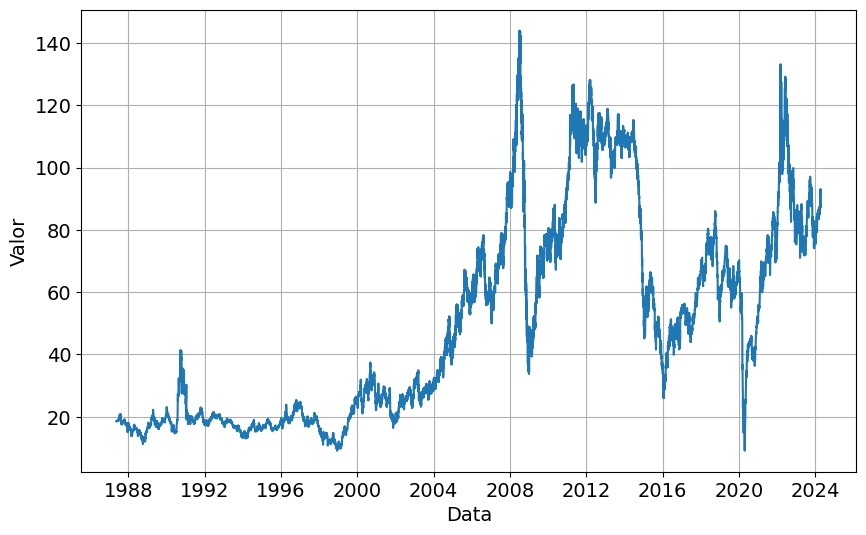

In [75]:
# Podemos fazer uma análise prévia e verificar a curva de crescimento do campo
# Valor do Barril ao decorrer dos anos. Nesse ponto podemos observar a grande variação
# dos valores do barril, ocasionado diversos fatores (conflitos, diminuição na produção dos países produtores, aumento da demanda).
sns.lineplot(x = 'Data', y='Valor', data=df_petroleo)
plt.grid()

In [76]:
# vamos trabalhar em um intervalo menor de tempo, por exemplo, somente os dados de 2023 e 2024
dados_atuais = df_petroleo[(df_petroleo.Data.dt.year == 2023) | (df_petroleo.Data.dt.year == 2024)]
# dados_atuais = df_petroleo.query('Data >= "2023-01-01"')

In [77]:
# verificando a quantidade de registros nos anos informados
dados_atuais.shape

(329, 2)

<Axes: xlabel='Data', ylabel='Valor'>

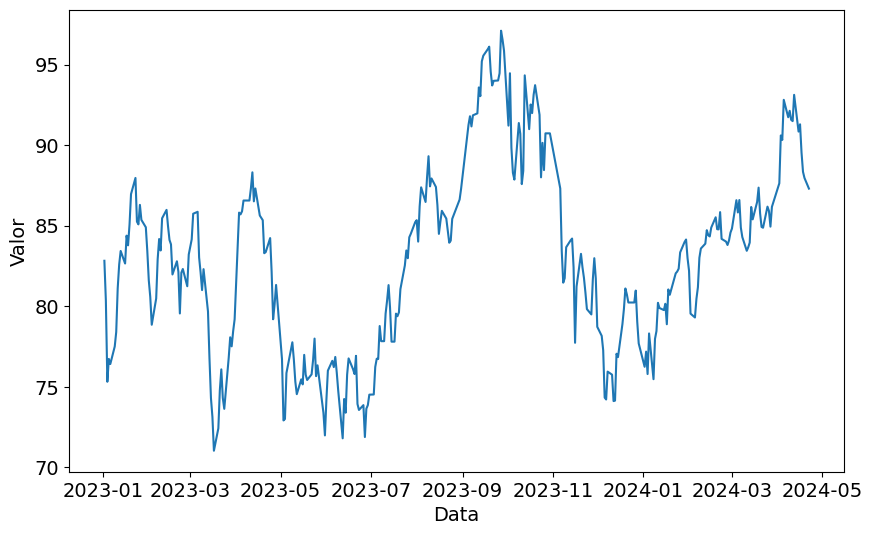

In [78]:
# verificando a curva de crescimento nos dados filtrados
sns.lineplot(x = 'Data', y='Valor', data=dados_atuais)

In [79]:
# Vamos observar agora a taxa de crescimento com que essas ações variam usando a diferenciação.
# Podemos observar que temos uma oscilação diária consideravel no valor do barril

dados_atuais['taxa_de_crescimento'] = dados_atuais.Valor.diff()

In [80]:
dados_atuais.head()

,Data,Valor,taxa_de_crescimento
328,2023-01-02,82.82,NaN
327,2023-01-03,80.36,-2.46
326,2023-01-04,75.31,-5.05
325,2023-01-05,76.73,1.42
324,2023-01-06,76.41,-0.32


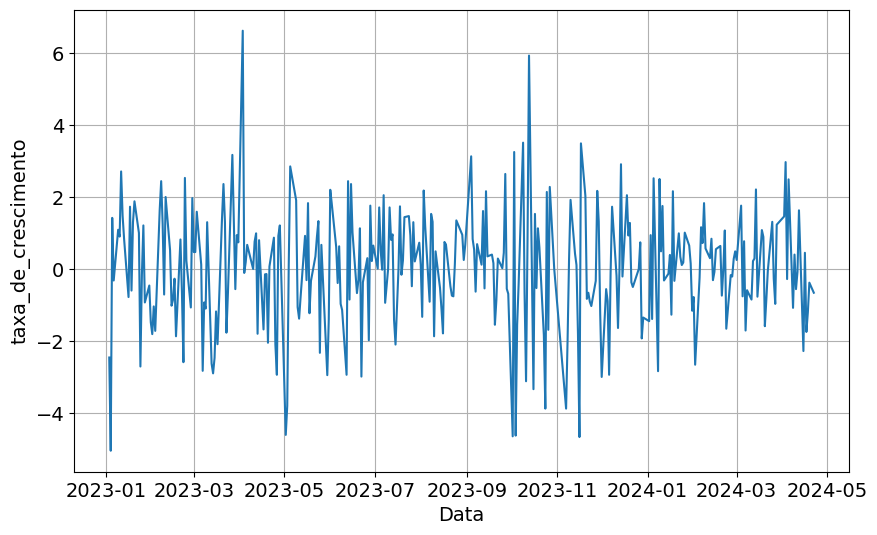

In [81]:
# no grafico abaixo podemos observar que a taxa de crescimento pode variar em torno de até U$ 12,00 no período informado

sns.lineplot(x = 'Data', y = 'taxa_de_crescimento', data=dados_atuais)
plt.grid()

<BarContainer object of 329 artists>

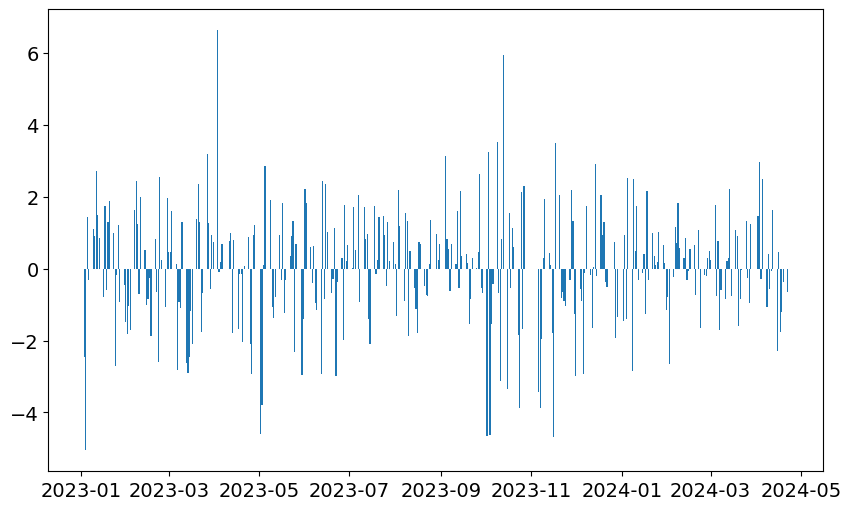

In [82]:
# podemos analisar de forma de grafico de barras.
# Vamos criar um novo dataframe com os dados já filtrados
plt.bar(dados_atuais.Data, dados_atuais.taxa_de_crescimento)

In [83]:
# Podemos melhorar o grafico realizando uma media movel dos dados
# Media movel considera uma janela de tempo, e serve para suavizar o efeito dos picos

dados_atuais['media_movel_valor'] = dados_atuais['Valor'].rolling(window=7, center=False).mean()

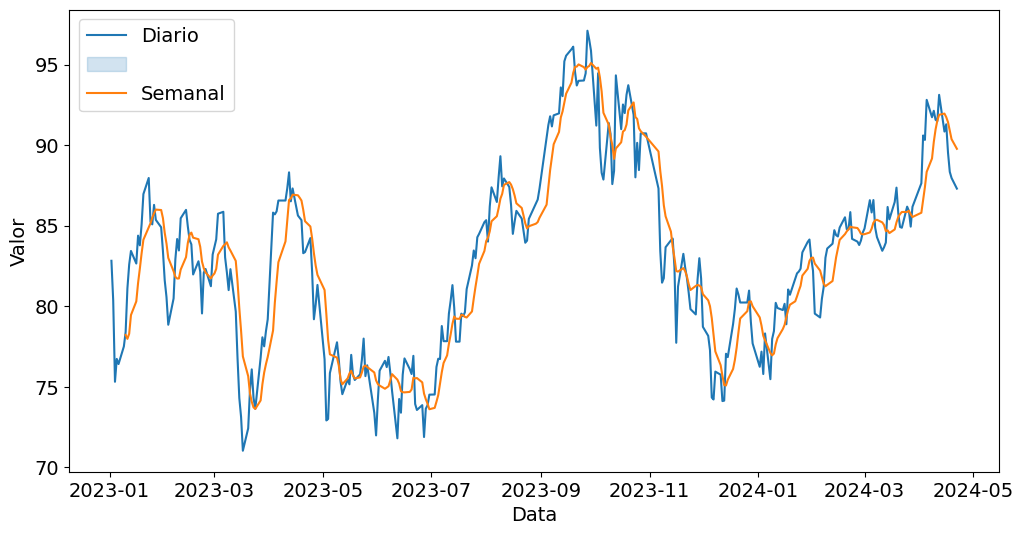

In [87]:
plt.figure(figsize=(12,6))
sns.lineplot(x='Data', y='Valor', data=dados_atuais)
sns.lineplot(x='Data', y='media_movel_valor', data=dados_atuais)
plt.legend(['Diario', '', 'Semanal'])

In [89]:
# usando a função de autocorrelação para descobrimos sazonalidade
from pandas.plotting import autocorrelation_plot

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

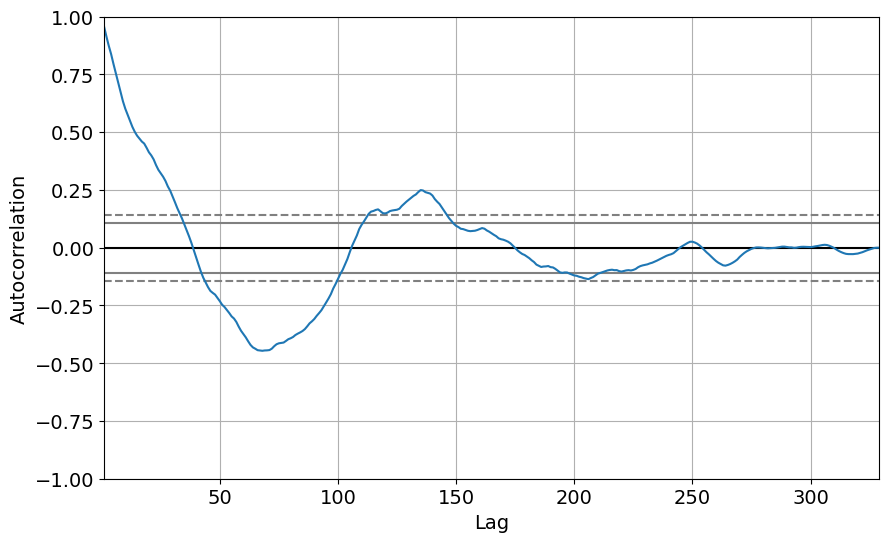

In [90]:
# o grafico abaixo indica que começa com uma autocorrelação forte, mas no decorrer dos dias (lags) esse valor se aproxima de zero,
# indicando que quase não existe uma sazonalidade quando o assunto é valor do barril
autocorrelation_plot(dados_atuais.Valor)

# CRIANDO MODELOS

## MODELO VERSAO 1 - Usando valores padrões do Prophet
Vamos criar um modelo usando a bilioteca Prophet, que segue o modelo sklearn. Criamos uma instância da classe Prophet e então chamamos seus métodos de ajuste e previsão.

In [101]:
# A entrada para o Prophet é sempre um dataframe com duas colunas: ds e y.
# A coluna ds (datestamp) deve ter um formato esperado pelo Pandas, idealmente AAAA-MM-DD para uma data ou AAAA-MM-DD HH:MM:SS
# para um carimbo de data/hora. A coluna y deve ser numérica e representa a medida que desejamos prever, no nosso caso, o valor do barril;

df = pd.DataFrame()
df['ds'] = dados_atuais.Data
df['y'] = dados_atuais.Valor

# df = df.sort_values(by=['ds'])

In [102]:
# importando a biblioteca Prophet

from prophet import Prophet

In [103]:
# criando o modelo (v1)
modelo = Prophet()

In [104]:
# treinando o modelo
modelo.fit(df)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/q334qbqz.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/mj7bf_fo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=68673', 'data', 'file=/tmp/tmp_yxc8qef/q334qbqz.json', 'init=/tmp/tmp_yxc8qef/mj7bf_fo.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modelyhafv2_8/prophet_model-20240501211723.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:17:23 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:17:23 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [105]:
# informando o numero de dias que sera feita a previsao (em dias)
dataframefuturo = modelo.make_future_dataframe(periods=30)

In [106]:
dataframefuturo.head(5)

,ds
0,2023-01-02
1,2023-01-03
2,2023-01-04
3,2023-01-05
4,2023-01-06


In [107]:
previsao = modelo.predict(dataframefuturo)

In [108]:
previsao.head()

,ds,trend,yhat_lower,yhat_upper,trend_lower,trend_upper,additive_terms,additive_terms_lower,additive_terms_upper,weekly,weekly_lower,weekly_upper,multiplicative_terms,multiplicative_terms_lower,multiplicative_terms_upper,yhat
0,2023-01-02,82.861547,79.442230,87.004940,82.861547,82.861547,0.555722,0.555722,0.555722,0.555722,0.555722,0.555722,0.0,0.0,0.0,83.417270
1,2023-01-03,82.830032,79.675051,86.980473,82.830032,82.830032,0.454015,0.454015,0.454015,0.454015,0.454015,0.454015,0.0,0.0,0.0,83.284047
2,2023-01-04,82.798517,79.373716,86.707798,82.798517,82.798517,0.086868,0.086868,0.086868,0.086868,0.086868,0.086868,0.0,0.0,0.0,82.885385
3,2023-01-05,82.767001,78.988195,86.652339,82.767001,82.767001,0.049152,0.049152,0.049152,0.049152,0.049152,0.049152,0.0,0.0,0.0,82.816154
4,2023-01-06,82.735486,79.237057,86.687164,82.735486,82.735486,0.384152,0.384152,0.384152,0.384152,0.384152,0.384152,0.0,0.0,0.0,83.119638


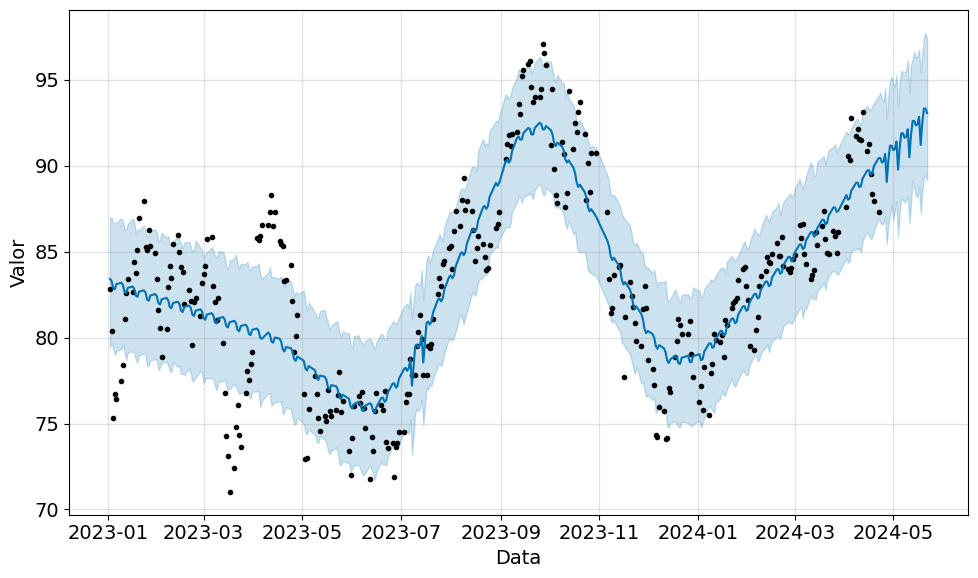

In [109]:
# yhat_lower e yhat_upper definem o intervalo de confiança (região em azul claro)
# yhat => valor previsto



modelo.plot(previsao, xlabel='Data', ylabel='Valor', figsize=(10,6));


# MODELO VERSAO 2
Nessa versão, iremos dividir os dados entre treino e teste

In [113]:
# criando um modelo v2 divindo em dados de treino e teste

# dados treino
df = pd.DataFrame()
df['ds'] = dados_atuais.Data[:300] # filtrando os dados até a posicao 300
df['y'] = dados_atuais.Valor[:300] # filtrando os dados até a posicao 300



In [114]:
# dados teste
df_teste = pd.DataFrame()
df_teste['ds'] = dados_atuais.Data[300:] # filtrando os dados de 300 pra frente
df_teste['y'] = dados_atuais.Valor[300:] # filtrando os dados de 300 pra frente

In [119]:
print(f'Total de dias para treino {df.shape[0]}')
print(f'Total de dias para teste {df_teste.shape[0]}')

Total de dias para treino 300
Total de dias para teste 29


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/7lx9isq2.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/d68xtucl.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=24365', 'data', 'file=/tmp/tmp_yxc8qef/7lx9isq2.json', 'init=/tmp/tmp_yxc8qef/d68xtucl.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modeli80lygc7/prophet_model-20240501214026.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:40:26 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:40:26 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


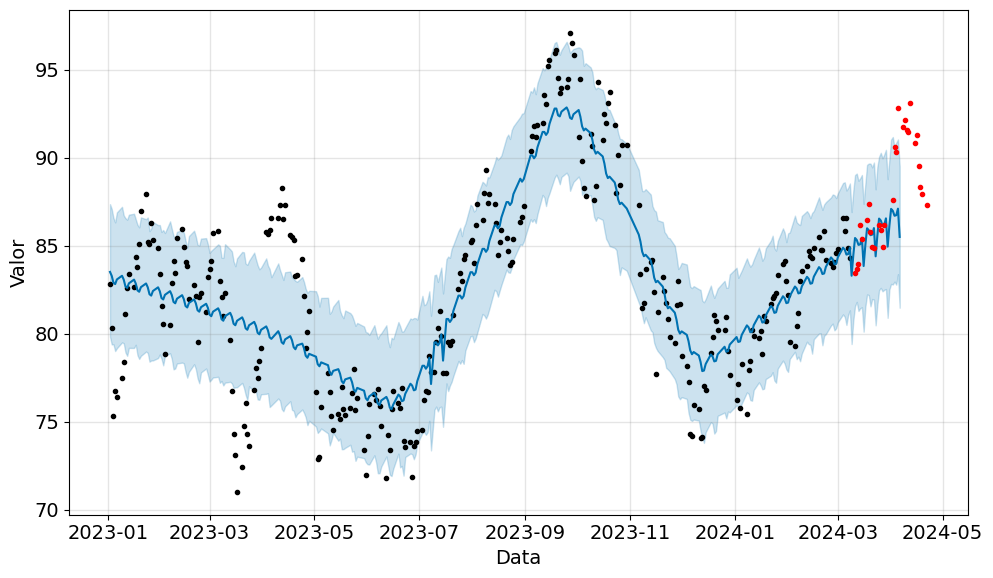

In [126]:
# Plotando os dados.
# Nesse gráfico, podemos observar o mesmo gráfico anterior, com a diferença que agora temos os pontos em
# vermelho, que são os dados de teste. Podemos observar que nosso modelo não está prevendo de forma correta,
# pois os pontos vermelhos estão muito fora do intervalo de confiança, e muito afastados da previsão (linha azul)

modelo = Prophet()
modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=29)
previsao = modelo.predict(dataframefuturo)
modelo.plot(previsao, xlabel='Data', ylabel='Valor', figsize=(10,6));
# plotando os 29 de teste e comparando com a previsão
plt.plot(df_teste.ds, df_teste.y, '.r')

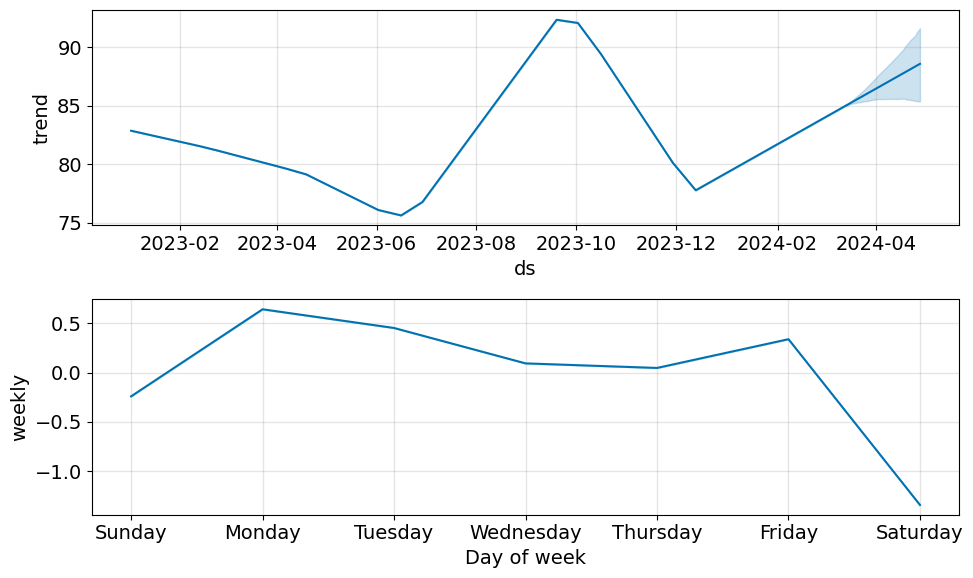

In [123]:
# decompondo os componentes do grafico em tendência e sazonalidade para um melhor entendimento
# No primeiro gráfico, temos uma tendência de queda no mês 06, e posteiormente, tendencia de alta.
# O cone ao final do gráfico indica um intervalo de confiança da previsão.

# No segundo gráfico, o modelo indica uma pequena sazolanidade semanal, indicando um pico maior do valor do barril
# na segunda-feira

modelo.plot_components(previsao, figsize=(10,6));

# trend => grafico de tendencia do preco do barril
# weekly => sazonalidade semanal (aos sábados o preco tem uma tendencia de queda, por não ter cotação)

# MODELO VERSAO 3 - Analisando mudança de tendências (changepoints)

Por padrão, o prophet faz a análise de tendência (padrão de crescimento/decrescimento) do gráfico de forma linear. Esse comportamento é muito importante para fazer as previsões, pois elas serão realizadas de acordo com um padrão do passado.


Será que essa tendência do gráfico anterior está correta? Não poderíamos alterar alguns parâmetros para ajustar a tendência nos pontos? Podemos ajustar esse pontos de tendência um pouco mais para ajudar nosso modelo?

Vamos agora ajustar os pontos de tendência para melhor ajustar o modelo. Para isso, vamos usar a add_changepoints_to_plot.

Pontos de tendência são pontos onde existe uma mudança de rumo na linha de tendência.


In [124]:
# trabalhando com change points (pontos de mudança de tendencia da serie temporal)

from prophet.plot import add_changepoints_to_plot

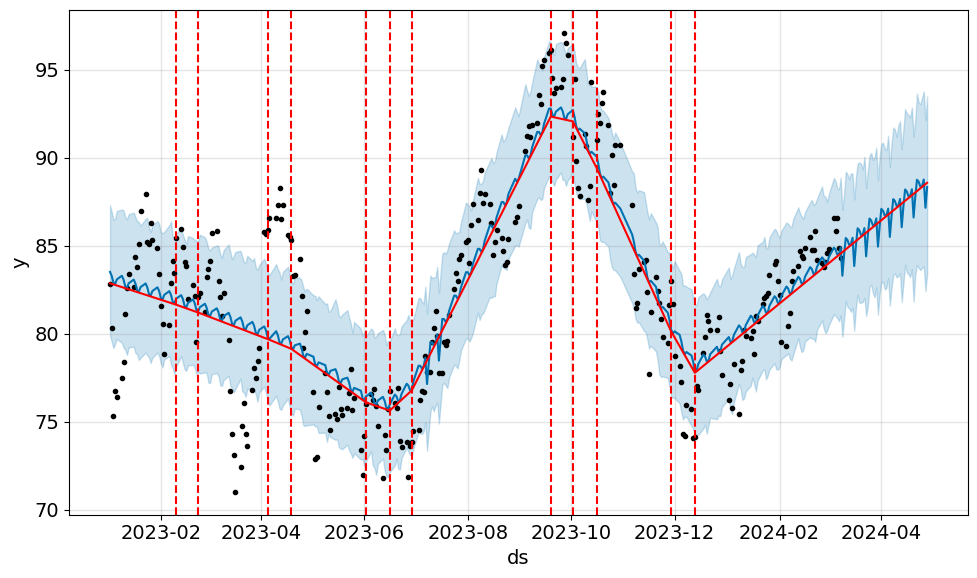

In [125]:
# Visualizando os change points => pontos de mudança de tendência

# Essa mudança de tendência é muito importante para o modelo. Pois ela é o comportamento que os dados tem
# em um determinado período, e não segnifica que no período completo a tendẽncia tenha o mesmo comportamento.
# No gráfico abaixo, estamos ajustando vários segmentos de reta para períodos de tempo na série temporal.
# Nesse primeiro momento, vamos deixar o prophet localizar esses pontos de mudanças de tendência

# Plotando o modelo
fig = modelo.plot(previsao, figsize=(10,6))
# Adicionando os pontos de mudança de tendência (linha vermelha vertical)
a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/x1q4tlsi.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/xyd3s89y.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79721', 'data', 'file=/tmp/tmp_yxc8qef/x1q4tlsi.json', 'init=/tmp/tmp_yxc8qef/xyd3s89y.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modelwso9dbm9/prophet_model-20240501214659.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
21:46:59 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
21:46:59 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


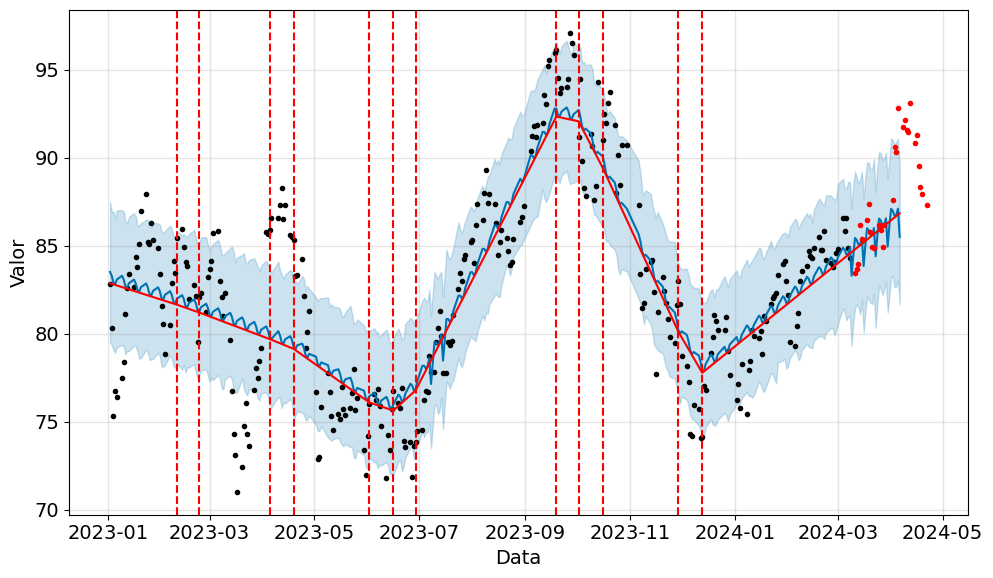

In [134]:
# Por padrão, o prophet configura o crescimento do gráfico com uma tendência linear. Mas como podemos observar no
# gráfico, ele apresenta um formato de "s" (siguimoide), que indica uma tendência logística, que envolve um
# crescimento exponencial, seguido de uma redução constante, até uma estabilização, assumindo uma curva em
# formato de "S"

# Podemos forçar o prophet a identificar um número maior de changepoints no decorrer da linha do gráfico. Isso
# ajudará o modelo nas previsões para identificar futuras mudança de tendências para os dados previstos.

# n_changepoints => altera o número de changepoints (quantidade de recortes na tendencia)
# changepoint_prior_scale => aumenta a área na série temporal onde ele pode enxergar changepoints. Padrao 0.05.
# changepoint_prior_scale é como se estivéssemos colocando uma lupa sobre o gráfico e identificando tendências
# mais sutis.

# Caso tenhamos datas que temos certeza de alteração de tendência, podemos inclui-la manualmente
# changepoints= ['01.01.2023'] => podemos adicionar changepoints específicos

# linha vermelha horizontal => tendencia da serie temporal
# linha vermelha vertical => changepoints
# Obs: Temos que alterar esses parâmetros com caulela, pois podemos criar um overfitting (ajustar demais os dados
# ao modelo, e dificultar a generalização)


modelo = Prophet(n_changepoints=25, changepoint_prior_scale=0.05)

# podemos também adicionar changepoints especificos
# modelo = Prophet(changepoints=['2023-10-03'])

modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=29)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, xlabel='Data', ylabel='Valor', figsize=(10,6));
# plotando os 29 dias restantes
plt.plot(df_teste.ds, df_teste.y, '.r')

a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

In [130]:
dados_atuais.head()

,Data,Valor,taxa_de_crescimento,media_movel_valor
328,2023-01-02,82.82,NaN,NaN
327,2023-01-03,80.36,-2.46,NaN
326,2023-01-04,75.31,-5.05,NaN
325,2023-01-05,76.73,1.42,NaN
324,2023-01-06,76.41,-0.32,NaN


# MODELO VERSAO 4
## Novo modelo ajustando os feriados, sazonalidade e finais de semana

Como não temos cotação aos finais de semana, temos que informar ao modelo quais são os dias que ele não deverá "processar" para fazer a previsão. Vamos informar também os feriados nacionais, para ver se há alguma interferência na previsão.

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/96ixwyk8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/nfe_fpv5.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=65701', 'data', 'file=/tmp/tmp_yxc8qef/96ixwyk8.json', 'init=/tmp/tmp_yxc8qef/nfe_fpv5.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_model2m9zun57/prophet_model-20240501220429.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:04:29 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:04:29 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


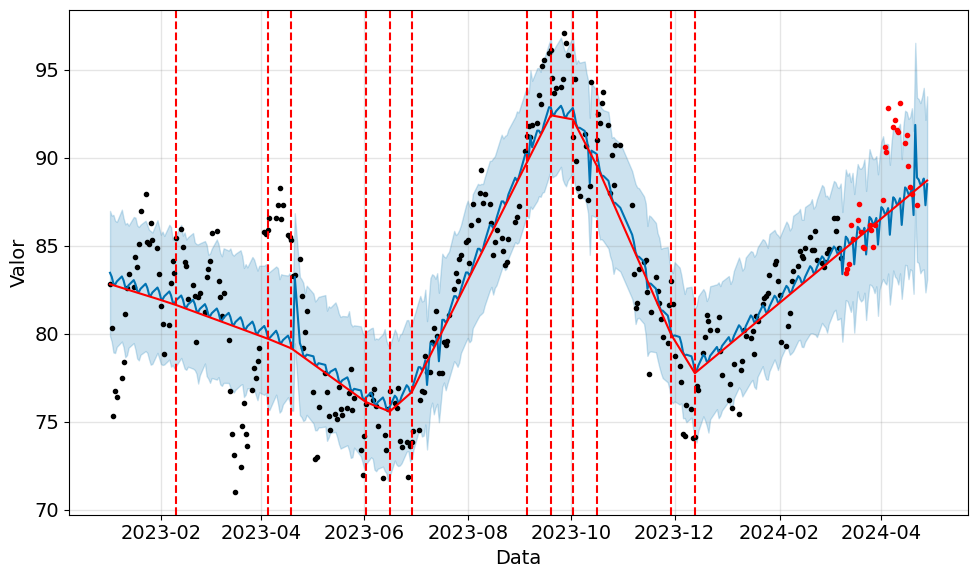

In [155]:
# Adicionando no modelo os feriados do Brasil
# Obs: caso tivéssemos paralização também nos feriados regionais, poderíamos criar um df com nome feriados
# e incluir no modelo da seguinte forma:
# modelo = Prophet(n_changepoints=25, changepoint_prior_scale=10, hollidays=feriados)


modelo = Prophet(n_changepoints=25)
modelo.add_country_holidays(country_name='BR')

modelo.fit(df)
dataframefuturo = modelo.make_future_dataframe(periods=51)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, xlabel='Data', ylabel='Valor', figsize=(10,6));
# plotando os 29 dias restantes
plt.plot(df_teste.ds, df_teste.y, '.r')

a = add_changepoints_to_plot(fig.gca(), modelo, previsao)

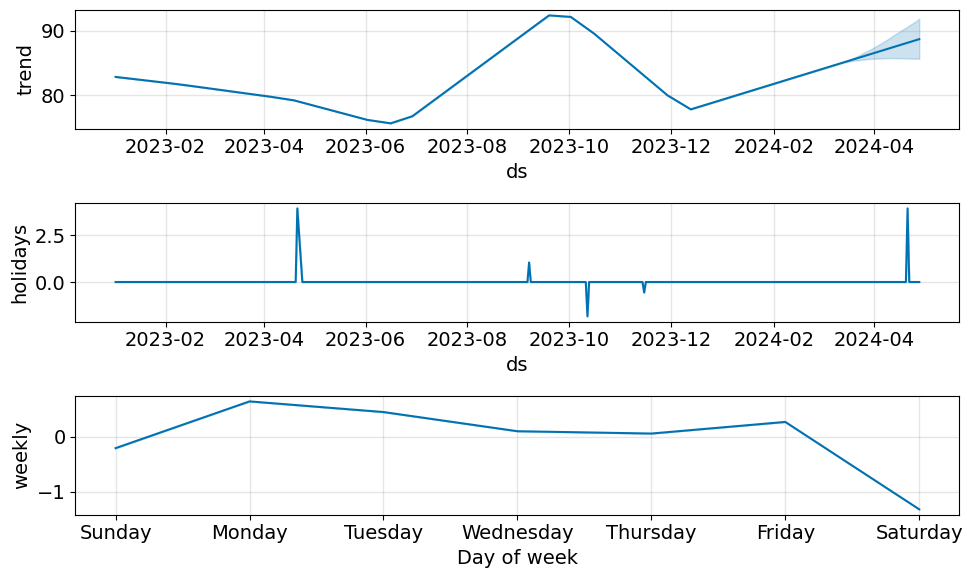

In [138]:
modelo.plot_components(previsao, figsize=(10,6));

In [151]:
# Idenficando o tipo de sazonalidade
# Por padrão o prophet coloca uma sazonalidade aditiva (seasonality_mode=additive)
# Vamos testar agora com a sazonalidade multiplicativa

# Aditiva: É quando a série apresenta flutuações sazonais mais ou menos constantes,
# não importando o nível global da série.

# Multiplicativa: O tamanho das flutuações sazonais variam dependendo do nível global da série.

# criando um novo modelo com sazonalidade multiplicativa
modelo_multiplicativa = Prophet(n_changepoints=25,changepoint_prior_scale=1.0, seasonality_mode='multiplicative')
modelo_multiplicativa.add_country_holidays(country_name='BR')
modelo_multiplicativa.fit(df)
dataframefuturo = modelo_multiplicativa.make_future_dataframe(29)
previsao_multiplicativa = modelo_multiplicativa.predict(dataframefuturo)

# fig = modelo_multiplicativa.plot(previsao_multiplicativa, xlabel='Data', ylabel='Valor', figsize=(10,6));


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/7vslibo0.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/xi4p87ks.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=4802', 'data', 'file=/tmp/tmp_yxc8qef/7vslibo0.json', 'init=/tmp/tmp_yxc8qef/xi4p87ks.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modelzqmiuc8u/prophet_model-20240501220219.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:02:19 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:02:20 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


In [152]:
# metricas

from sklearn.metrics import mean_absolute_error

In [153]:
# abaixo percebemos que ao alterar a sazonalidade para multiplicativa, a taxa de erro diminuiu consideravelmente

# sazonalidade aditiva
print(f'Sozonalidade Aditiva: {mean_absolute_error(df["y"], previsao["yhat"][:300])}')

# sazonalidade multiplicativa
print(f'Sozonalidade Aditiva: {mean_absolute_error(df["y"], previsao_multiplicativa["yhat"][:300])}')

# print(f'Sozonalidade Aditiva: mean_absolute_error(df["y"], previsao_multiplicativa["yhat"][:300])}')

Sozonalidade Aditiva: 2.259964974762001
Sozonalidade Aditiva: 1.3340939076856626


In [144]:
# sazonalidade multiplicativa
mean_absolute_error(df['y'], previsao_multiplicativa['yhat'][:300])

1.3340939076856626

# MODELO VERSAO 5 - Tratando outiliers



In [168]:
# criando um novo dataframe para se retirar os outliers.
# No nosso caso, vamos definir outiliers como os dados fora do intervalo de confiança. Pode ter ocorrido
# um evento qualquer em determinados dias que fez os valor do barril subir ou descer abruptamente.
# Como é um evento esporárido, podemos excluí-los para não prejudicar nosso modelo.

novo_y = df.reset_index()
df_sem_outlier = novo_y[(novo_y.y > previsao['yhat_lower'][:300]) & (novo_y.y < previsao['yhat_upper'][:300])]



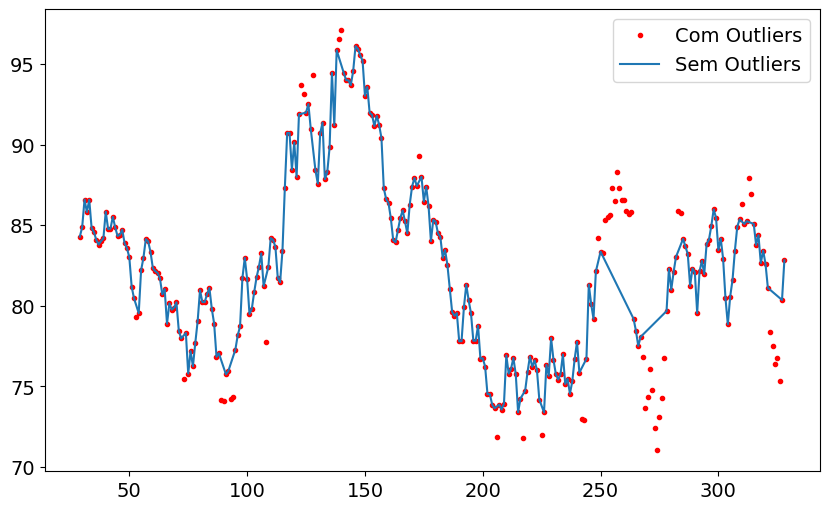

In [170]:
# o grafico acima apresenta os dados com outliers sobrepostos aos dados sem outliers

plt.figure(figsize=(10,6))
plt.plot(df.index, df['y'], '.r')
plt.plot(df_sem_outlier['index'], df_sem_outlier.y)
plt.legend(labels=['Com Outliers', 'Sem Outliers'])

In [165]:
df_sem_outlier = df_sem_outlier[['ds', 'y']]

In [166]:
df_sem_outlier.head()

,ds,y
0,2023-01-02,82.82
1,2023-01-03,80.36
7,2023-01-11,81.11
8,2023-01-12,82.59
9,2023-01-13,83.43


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/v95563j8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/gmgisntk.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=97821', 'data', 'file=/tmp/tmp_yxc8qef/v95563j8.json', 'init=/tmp/tmp_yxc8qef/gmgisntk.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modeldunqjxwl/prophet_model-20240501221309.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
22:13:09 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:13:10 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


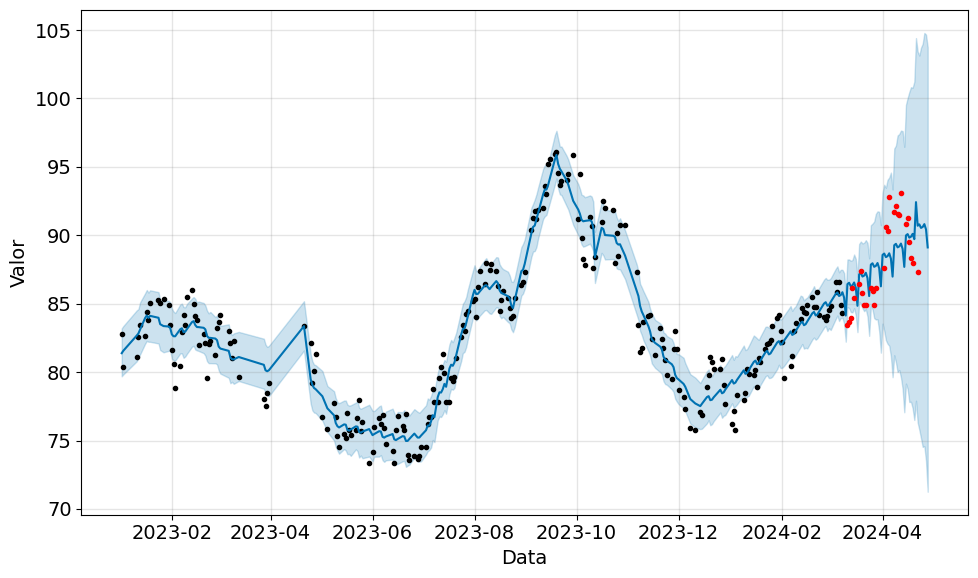

In [173]:
modelo = Prophet(n_changepoints=25,changepoint_prior_scale=1.0)
modelo.add_country_holidays(country_name='BR')

modelo.fit(df_sem_outlier)
dataframefuturo = modelo.make_future_dataframe(periods=51)
previsao = modelo.predict(dataframefuturo)
fig = modelo.plot(previsao, xlabel='Data', ylabel='Valor', figsize=(10,6));
# plotando os 51 dias restantes
plt.plot(df_teste.ds, df_teste.y, '.r')



In [175]:
mean_absolute_error(df_sem_outlier['y'], previsao['yhat'][:248])

1.1467478176431543

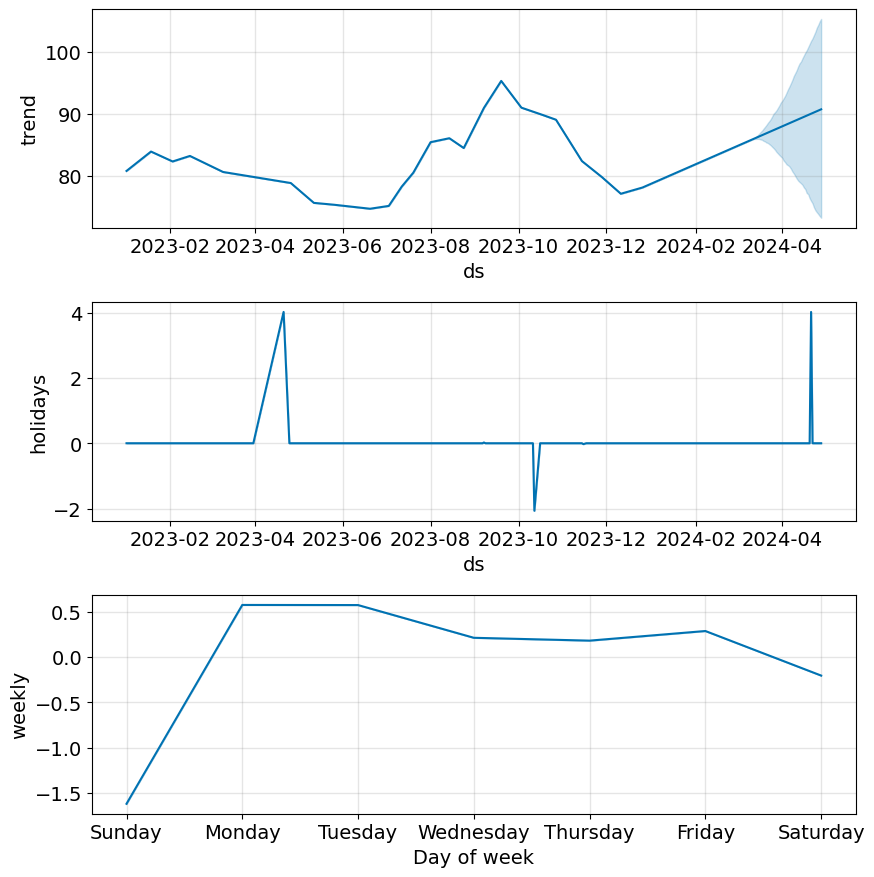

In [176]:
modelo.plot_components(previsao);

In [178]:
# Calculando a taxa de erro entre aditiva e multiplicativa com RMSE e MAE com dados sem outliers
# Observamos que a taxa de erro foi bem menor após retirarmos os valores extremos.
from sklearn.metrics import mean_squared_error
print('MAE', mean_squared_error(df_sem_outlier['y'], previsao['yhat'][:248]))
print('RMSE', mean_absolute_error(df_sem_outlier['y'], previsao['yhat'][:248]))

MAE 1.9922981656527692
RMSE 1.1467478176431543


# METRICAS

In [180]:
from prophet.diagnostics import cross_validation

In [181]:

# Validação Cruzada
# O Prophet inclui funcionalidade para validação cruzada de séries temporais para medir erros
# de previsão usando dados históricos. Isso é feito selecionando pontos de corte no histórico,
# e para cada um deles ajustando o modelo utilizando dados apenas até aquele ponto de corte.
df_cv = cross_validation(modelo, initial='180 days', period='30 days', horizon='30 days')

INFO:prophet:Making 8 forecasts with cutoffs between 2023-07-12 00:00:00 and 2024-02-07 00:00:00


  0%|          | 0/8 [00:00<?, ?it/s]

DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/0v11b9wk.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/ircm976c.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=54372', 'data', 'file=/tmp/tmp_yxc8qef/0v11b9wk.json', 'init=/tmp/tmp_yxc8qef/ircm976c.json', 'output', 'file=/tmp/tmp_yxc8qef/prophet_modelybtug1p1/prophet_model-20240501221842.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
22:18:42 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
22:18:43 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/jvkj82nd.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp_yxc8qef/prqh0x_m.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local

In [183]:
# Podemos observar que dividimos em 8 períodos
# cutoff => pontos de corte
cutoff = df_cv['cutoff'].unique()
print(f'{cutoff.size} é a quantidade de períodos')
print(f'{cutoff}')

8 é a quantidade de períodos
<DatetimeArray>
['2023-07-12 00:00:00', '2023-08-11 00:00:00', '2023-09-10 00:00:00',
 '2023-10-10 00:00:00', '2023-11-09 00:00:00', '2023-12-09 00:00:00',
 '2024-01-08 00:00:00', '2024-02-07 00:00:00']
Length: 8, dtype: datetime64[ns]


In [186]:
janela = 0

In [187]:
cutoff = df_cv['cutoff'].unique()[janela]
df_cv_cut = df_cv[df_cv.cutoff.values == cutoff]

Text(0.5, 0, 'ds')

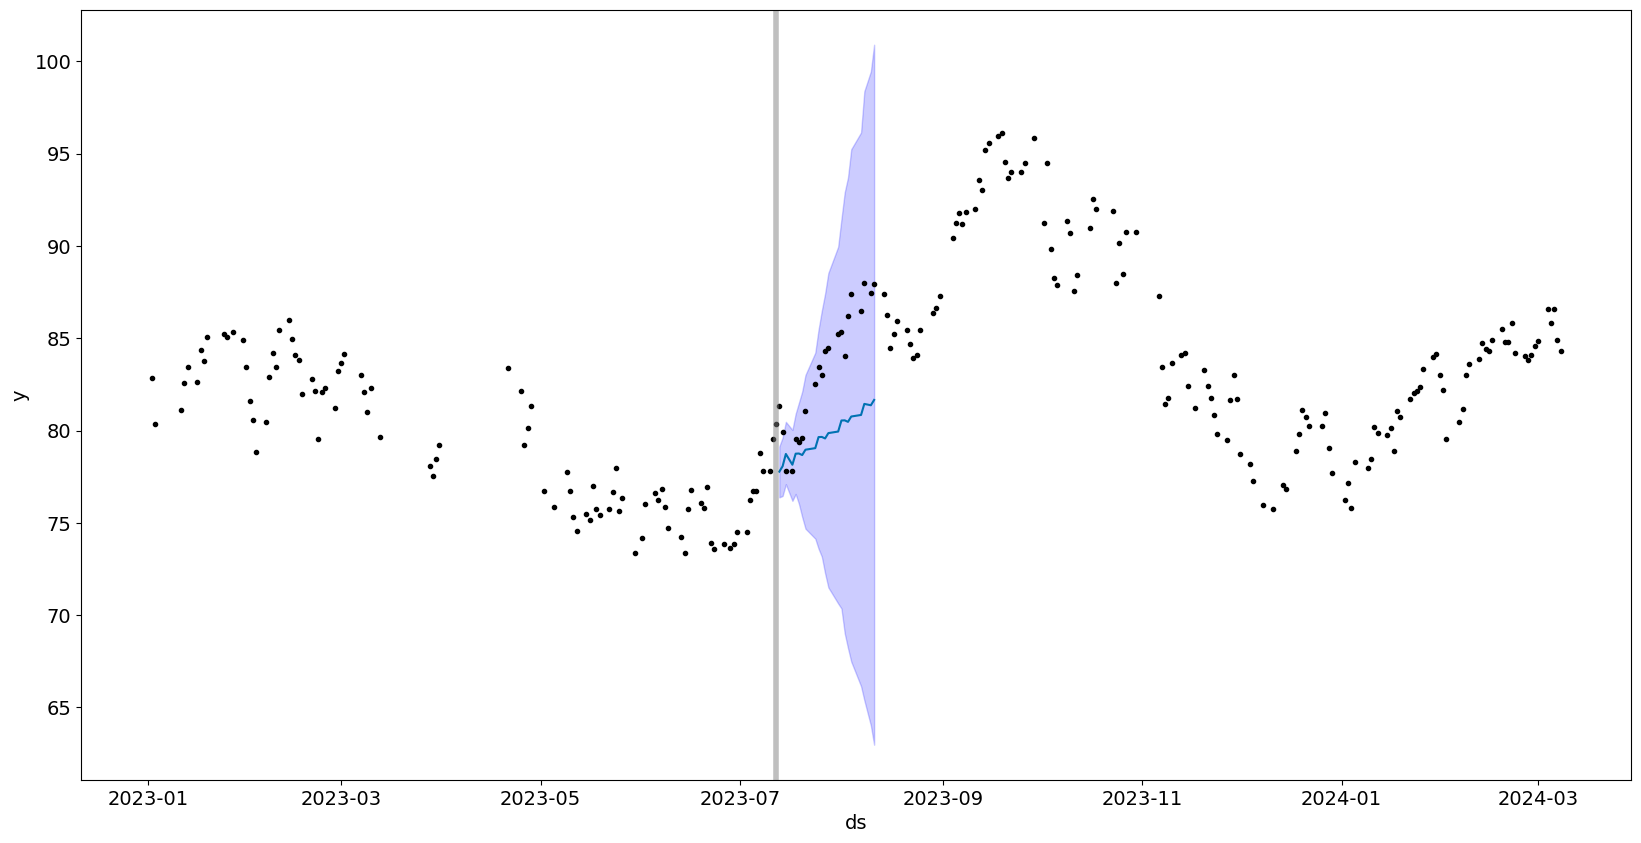

In [188]:
fig = plt.figure(figsize=(20,10))
ax = fig.add_subplot(111)
ax.plot(modelo.history['ds'].values, modelo.history['y'], 'k.')
ax.plot(df_cv_cut['ds'].values, df_cv_cut['yhat'], ls='-', c='#0072B2')
ax.fill_between(df_cv_cut['ds'].values, df_cv_cut['yhat_lower'],
                df_cv_cut['yhat_upper'], color='blue',
                                alpha=0.2)
ax.axvline(x=pd.to_datetime(cutoff), c='gray', lw=4, alpha=0.5)
ax.set_ylabel('y')
ax.set_xlabel('ds')

In [189]:
# O performance_metrics utilitário pode ser usado para calcular algumas estatísticas úteis do desempenho
# da previsão ( yhat, yhat_lowere yhat_uppercomparado a y), como uma função da distância do ponto de corte
# (a que distância no futuro estava a previsão).

# As estatísticas calculadas são:
# erro quadrático médio (MSE),
# erro quadrático médio (RMSE),
# erro absoluto médio (MAE),
# erro percentual médio absoluto (MAPE),
# erro percentual absoluto mediano (MDAPE) e cobertura das yhat_lowerestimativas yhat_upper.

# https://www.alura.com.br/artigos/metricas-de-avaliacao-para-series-temporais

from prophet.diagnostics import performance_metrics

In [190]:
df_p = performance_metrics(df_cv)

In [191]:
df_p

,horizon,mse,rmse,mae,mape,mdape,smape,coverage
0,3 days,13.393090,3.659657,3.255127,0.038480,0.031266,0.038623,0.066667
1,4 days,14.583168,3.818791,3.418198,0.040120,0.037199,0.040537,0.133333
2,5 days,13.534333,3.678904,3.110716,0.036074,0.037199,0.036524,0.333333
3,6 days,12.190652,3.491511,2.918719,0.033706,0.032654,0.033733,0.383333
4,7 days,11.873952,3.445860,2.920945,0.034121,0.038915,0.034075,0.333333
5,8 days,14.900320,3.860093,3.443082,0.040304,0.039012,0.040540,0.222222
6,9 days,16.829072,4.102325,3.782888,0.044390,0.039371,0.045102,0.186667
7,10 days,21.065834,4.589753,4.283085,0.050312,0.047486,0.051276,0.133333
8,11 days,24.901334,4.990124,4.641574,0.055039,0.047486,0.056078,0.211111
9,12 days,27.194024,5.214789,4.858535,0.057781,0.047486,0.058428,0.333333


In [192]:
from prophet.plot import plot_cross_validation_metric

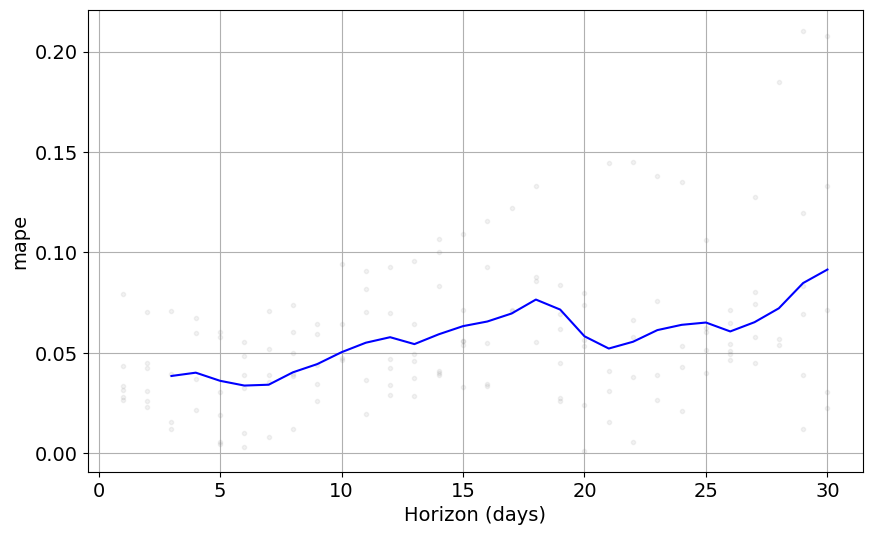

In [194]:
plot_cross_validation_metric(df_cv, metric='mape');